# Machine Learning: Intermediate report

+ 佐田悠生 (18M14291)

Prepare an environment for running Python codes on Jupyter notebook. The most easiest way is to use [Google Colaboratory](https://colab.research.google.com/).

Write codes for the following three (and one optional) problems, and submit the notebook (`.ipynb`) as well as its HTML conversion (`.html`). *We do not accept a report in other formats (e.g., Word, PDF)*. Write a code at the specified cell in the notebook. One can add more cells if necessary.

These are the links to the sample codes used in the lecture:

+ [Binary classification](https://github.com/chokkan/deeplearningclass/blob/master/mlp_binary.ipynb)
+ [MNIST](https://github.com/chokkan/deeplearningclass/blob/master/mnist.ipynb)

## 1. Multi-class classification on MNIST

Train a model on the training set of MNIST, and report the accuracy of the model on the test set. One can use the same code shown in the lecture. Write a code here and show the output.

In [1]:
!nvidia-smi #make sure you have gpu, you could have it in a runtime setting-menu

Tue Jul 17 14:29:08 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.111                Driver Version: 384.111                   |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    71W / 149W |    156MiB / 11439MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
# prepair chainer

!apt -y install libcusparse8.0 libnvrtc8.0 libnvtoolsext1
!ln -snf /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so.8.0 /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so
!pip install cupy-cuda80 chainer

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libcusparse8.0 is already the newest version (8.0.61-1).
libnvrtc8.0 is already the newest version (8.0.61-1).
libnvtoolsext1 is already the newest version (8.0.61-1).
0 upgraded, 0 newly installed, 0 to remove and 7 not upgraded.


In [0]:
from chainer.datasets import mnist
from chainer import iterators
import chainer
import chainer.links as L
import chainer.functions as F
from chainer import optimizers
from chainer import training
from chainer.training import extensions

In [4]:
train, test = mnist.get_mnist()

batchsize = 128

train_iter = iterators.SerialIterator(train, batchsize)
test_iter = iterators.SerialIterator(test, batchsize, False, False)


class MLP(chainer.Chain):

    def __init__(self):
        super(MLP, self).__init__()
        with self.init_scope():
            self.l1=L.Linear(None, 100)
            self.l2=L.Linear(None, 100)
            self.l3=L.Linear(None, 10)
            self.bn1=L.BatchNormalization(100)
            self.bn2=L.BatchNormalization(100)
            self.bn3=L.BatchNormalization(10)

    def __call__(self, x):
        h1 = F.relu(self.bn1(self.l1(x)))
        h2 = F.relu(self.bn2(self.l2(h1)))
        return self.bn3(self.l3(h2))

gpu_id = 0

model = MLP()
model = L.Classifier(model)

if gpu_id >= 0:
    model.to_gpu(gpu_id)
    
max_epoch = 20

# optimizer
optimizer = optimizers.SGD()
optimizer.setup(model)

# Updater
updater = training.StandardUpdater(train_iter, optimizer, device=gpu_id)
# Trainer
trainer = training.Trainer(updater, (max_epoch, 'epoch'), out='mnist_result')

trainer.extend(extensions.LogReport())
trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'main/accuracy', 'validation/main/loss', 'validation/main/accuracy', 'elapsed_time']))
trainer.extend(extensions.PlotReport(['main/loss', 'validation/main/loss'], x_key='epoch', file_name='loss.png'))
trainer.extend(extensions.PlotReport(['main/accuracy', 'validation/main/accuracy'], x_key='epoch', file_name='accuracy.png'))
#trainer.extend(extensions.snapshot(), trigger=(4, 'epoch'))
trainer.extend(extensions.Evaluator(test_iter, model, device=gpu_id))
trainer.extend(extensions.dump_graph('main/loss'))
#trainer.extend(extensions.ProgressBar())
trainer.run()

epoch       main/loss   main/accuracy  validation/main/loss  validation/main/accuracy  elapsed_time
1           0.773273    0.835055       0.470153              0.918414                  5.79132       
2           0.430793    0.920792       0.334916              0.93928                   11.0213       
3           0.328759    0.936784       0.263646              0.947785                  16.1556       
4           0.271639    0.944712       0.223071              0.952927                  21.2671       
5           0.232627    0.952042       0.198635              0.956092                  26.4303       
6           0.205525    0.956556       0.176007              0.962025                  31.6024       
7           0.186348    0.961221       0.161429              0.963212                  36.7991       
8           0.168055    0.963909       0.149813              0.965289                  41.9904       
9           0.153887    0.967184       0.14039               0.967464               

## 2. Confusion matrix

Show a confusion matrix of the predictions of the model on the test set. This is an example of a confusion matrix.

![example](https://github.com/chokkan/deeplearningclass/blob/master/assignment/example-confusion-matrix.png?raw=1)

Write a code here and show the confusion matrix.

In [0]:
import pandas as pd
import seaborn as sn
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# plot confution matrix from labels
def print_cmx(y_true, y_pred):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)

    plt.figure(figsize = (10,7))
    sn.heatmap(df_cmx, annot=True)
    plt.show()

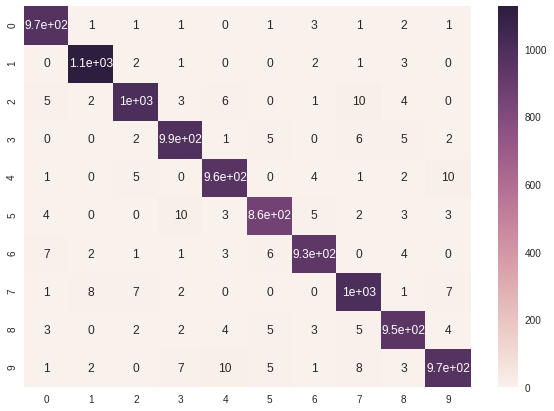

In [6]:
from chainer.dataset import concat_examples
import numpy as np
chainer.config.train = False

# predict test data again
# make sure you have a gpu and a trained model
test_iter = iterators.SerialIterator(test, batchsize, False, False)

pred_prob, gt_label = np.zeros((0,10)), []
while True:
    img, gt = concat_examples(test_iter.next(), device=gpu_id)
    pred = model.predictor(img)
    gt_label=np.append(gt_label, chainer.cuda.to_cpu(gt)).astype(np.int)
    pred_prob=np.r_[pred_prob, chainer.cuda.to_cpu(pred.data)]
    if test_iter.is_new_epoch: break
      
pred_label=np.argmax(pred_prob,axis=1)
# plot
print_cmx(gt_label, pred_label)


## 3. Top-3 confusing examples

Show the top three images where the model misrecognized their digits with strong confidences. More specifically, let $y_n$ and $\hat{y}_n$ the true and predicted, respectively, digits of the image $x_n$. We want to find three images with high $P(\hat{y}_n | x_n)$ when $y_n \neq \hat{y}_n$.

Please show $y_n$, $P(y_n | x_n)$, $\hat{y}_n$, and $P(\hat{y}_n | x_n)$. This is an example of an output for an image (you need this kind of outputs for top-three images).

![example](https://github.com/chokkan/deeplearningclass/blob/master/assignment/example-confusing-sample.png?raw=1)

Write a code here and show the output.

[0.99880926 0.98956671 0.96939958]
ground truth: [2 5 8]
pred: [7 6 7]


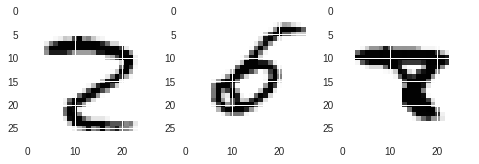

In [7]:
top=3

prob=np.max(F.softmax(pred_prob,axis=1).data,axis=1) #max predicted probability
pos=(pred_label!=gt_label) # index posision of wrong label
wrong=prob[pos] # probability of wrong label
idx=np.argsort(wrong)[::-1] # sort index of wrong

print(wrong[idx][:top])
print('ground truth:',gt_label[pos][idx][:top])
print('pred:',pred_label[pos][idx][:top])

img,_=concat_examples(test)
img=img[pos][idx][:top]

for i in range(top):
  plt.subplot(1,top,i+1)
  plt.imshow(img[i].reshape(28,28))

## 4. Sample codes in other DL frameworks

(Advanced; optional) Implement one or more sample code(s) with a different deep learning framework (e.g., Chainer, TensorFlow, DyNet) corresponding to the slides 60-66 in binary classification. *When subitting an answer to this problem, please agree that some of the submitted codes will be distributed on the Web site to improve this lecture.*

#Computing gradients with chainer

In [8]:
import chainer
#from chainer.cuda import cupy as xp
import numpy as np
from chainer import functions as F

dtype=np.float32
x=chainer.Variable(np.array([1,1,1], dtype=dtype))
w=chainer.Variable(np.array([1.0, 1.0, -1.5], dtype=dtype))
loss=-F.log(F.sigmoid(F.tensordot(x,w,1)))
loss.grad=np.ones(loss.data.shape, dtype=dtype)
loss.backward()

print(loss.data)
print(w.grad)

0.47407696
[-0.37754062 -0.37754062 -0.37754062]


#Training SLP using SGD with chainer

In [9]:
import chainer
import numpy as np
from chainer import functions as F

dtype=np.float32

# Training data for NAND.
x = chainer.Variable(np.array([[0, 0, 1], [0, 1, 1], [1, 0, 1], [1, 1, 1]], dtype=dtype))
y = chainer.Variable(np.array([[1], [1], [1], [0]], dtype=dtype))
w =chainer.Variable(np.random.randn(3, 1).astype(dtype))

eta = 0.5

for t in range(100):
    # y_pred = \sigma(x \cdot w)
    y_pred = F.sigmoid(F.tensordot(x,w,1))
    ll = y * y_pred + (1 - y) * (1 - y_pred)
    loss = -F.sum(F.log(ll))      # The loss value.
    #print(t, loss.item())
    loss.backward()             # Compute the gradients of the loss.
    
    with chainer.configuration.using_config('enable_backprop', False):
        w -= eta * w.grad       # Update weights using SGD.
        w.cleargrad()          # Clear the gradients for the next iteration.

print('w:',w.data)
print('predict:',F.sigmoid(F.tensordot(x,w,1)).data)

w: [[-4.337484 ]
 [-4.3383975]
 [ 6.6975546]]
predict: [[0.9987676 ]
 [0.91365933]
 [0.9137314 ]
 [0.1214973 ]]


#Training MLP using SGD with chainer

In [10]:
import chainer
import numpy as np
from chainer import functions as F

dtype=np.float32

# Training data for XOR.
x = chainer.Variable(np.array([[0, 0, 1], [0, 1, 1], [1, 0, 1], [1, 1, 1]], dtype=dtype))
y = chainer.Variable(np.array([[0], [1], [1], [0]], dtype=dtype))
w1 =chainer.Variable(np.random.randn(3, 2).astype(dtype))
w2 =chainer.Variable(np.random.randn(2, 1).astype(dtype))
b2 =chainer.Variable(np.random.randn(1).astype(dtype))

eta = 0.5
for t in range(1000):
    # y_pred = \sigma(w_2 \cdot \sigma(x \cdot w_1) + b_2)
    y_pred = F.sigmoid(F.bias(F.tensordot(F.sigmoid(F.tensordot(x,w1,1)),w2,1),b2))
    ll = y * y_pred + (1 - y) * (1 - y_pred)
    loss = -F.sum(F.log(ll)) 
    #print(t, loss.item())
    loss.backward()
    
    with chainer.configuration.using_config('enable_backprop', False):
        # Update weights using SGD.
        w1 -= eta * w1.grad
        w2 -= eta * w2.grad
        b2 -= eta * b2.grad
        
        # Clear the gradients for the next iteration.
        w1.cleargrad()
        w2.cleargrad()
        b2.cleargrad()

print('w1',w1.data)
print('w2',w2.data)
print('b2',b2.data)
print('pred',F.sigmoid(F.bias(F.tensordot(F.sigmoid(F.tensordot(x,w1,1)),w2,1),b2)).data)

w1 [[ 5.5076585 -6.811219 ]
 [ 5.5071445 -6.808606 ]
 [-8.528116   2.766697 ]]
w2 [[-11.955854]
 [-11.855958]]
b2 [5.8308444]
pred [[0.00483903]
 [0.9937593 ]
 [0.9937609 ]
 [0.00544786]]


#Training SLP with high-level NN chainer

In [11]:
import chainer
import numpy as np
from chainer import functions as F
from chainer import links as L
chainer.config.train = True

dtype=np.float32

# Training data for NAND.
x = chainer.Variable(np.array([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=dtype))
y = chainer.Variable(np.array([[1], [1], [1], [0]], dtype=np.int32))

# Define a neural network using high-level modules.
model = chainer.Sequential(
    L.Linear(2, 1, nobias=False),   # 2 dims (with bias) -> 1 dim
)
# Binary corss-entropy loss after sigmoid function.
loss_fn=F.sigmoid_cross_entropy

eta = 0.5
for t in range(500):
    y_pred = model(x)
    loss = loss_fn(y_pred, y, normalize=False)
    #print(t, loss.data)
    
    model.cleargrads()                   # Zero-clear the gradients.
    loss.backward()                     # Compute the gradients.
        
    with chainer.configuration.using_config('enable_backprop', False):
        for layer in model._layers:
            layer.W -= eta * layer.W.grad   # Update the parameters using SGD.
            layer.b -= eta * layer.b.grad   # Update the parameters using SGD.

F.sigmoid(model(x))

variable([[0.99923337],
          [0.92522883],
          [0.9252217 ],
          [0.10511732]])

#Training MLP with high-level NN chainer

In [16]:
import chainer
import numpy as np
from chainer import functions as F
from chainer import links as L
chainer.config.train = True

dtype=np.float32

# Training data for XOR.
x = chainer.Variable(np.array([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=dtype))
y = chainer.Variable(np.array([[0], [1], [1], [0]], dtype=np.int32))

# Define a neural network using high-level modules.
init=chainer.initializers.HeNormal()
model = chainer.Sequential(
    L.Linear(2, 2, nobias=False, initialW=init),
    F.sigmoid,
    L.Linear(2, 1, nobias=False, initialW=init),
)
# Binary corss-entropy loss after sigmoid function.
loss_fn=F.sigmoid_cross_entropy

eta = 0.5
for t in range(1000):
    y_pred = model(x)
    loss = loss_fn(y_pred, y, normalize=False)
    #print(t, loss.data)
    
    model.cleargrads()                   # Zero-clear the gradients.
    loss.backward()                     # Compute the gradients.
    
    with chainer.configuration.using_config('enable_backprop', False):
        for layer in model._layers:
            try:
                layer.W -= eta * layer.W.grad   # Update the parameters using SGD.
                layer.b -= eta * layer.b.grad   # Update the parameters using SGD.
            except:
                pass
                
F.sigmoid(model(x))


variable([[0.03585517],
          [0.9508016 ],
          [0.9693854 ],
          [0.02983508]])

#SLP with high-level NN modules and optimizers

In [13]:
import chainer
import numpy as np
from chainer import functions as F
from chainer import links as L
chainer.config.train = True

dtype=np.float32

# Training data for NAND.
x = chainer.Variable(np.array([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=dtype))
y = chainer.Variable(np.array([[1], [1], [1], [0]], dtype=np.int32))

# Define a neural network using high-level modules.
model = chainer.Sequential(
    L.Linear(2, 1, nobias=False),   # 2 dims (with bias) -> 1 dim
)

# Binary corss-entropy loss after sigmoid function.
loss_fn=F.sigmoid_cross_entropy

eta = 0.5

# Optimizer based on SGD (change "SGD" to "Adam" to use Adam)
optimizer = chainer.optimizers.SGD(lr=0.5)
optimizer.setup(model)

for t in range(1000):
    y_pred = model(x)
    loss = loss_fn(y_pred, y, normalize=False)
    #print(t, loss.data)
    
    model.zerograds()
    loss.backward()                     # Compute the gradients.
    optimizer.update()
                
F.sigmoid(model(x))


variable([[0.99990284],
          [0.9607514 ],
          [0.9607508 ],
          [0.05501705]])

#MLP with high-level NN modules and optimizers

In [62]:
import chainer
import numpy as np
from chainer import functions as F
from chainer import links as L
chainer.config.train = True

dtype=np.float32

# Training data for XOR.
x = chainer.Variable(np.array([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=dtype))
y = chainer.Variable(np.array([[0], [1], [1], [0]], dtype=np.int32))

# Define a neural network using high-level modules.
model = chainer.Sequential(
    L.Linear(2, 2, nobias=False),
    F.sigmoid,
    L.Linear(2, 1, nobias=False),
)

# Binary corss-entropy loss after sigmoid function.
loss_fn=F.sigmoid_cross_entropy


# Optimizer based on SGD (change "SGD" to "Adam" to use Adam)
optimizer = chainer.optimizers.SGD(lr=0.5)
optimizer.setup(model)

for t in range(1000):
    y_pred = model(x)
    loss = loss_fn(y_pred, y, normalize=False)
    #print(t, loss.data)
    
    model.zerograds()
    loss.backward()                     # Compute the gradients.
    optimizer.update()
                
F.sigmoid(model(x))


variable([[0.05223453],
          [0.938006  ],
          [0.9492377 ],
          [0.04352644]])